## Data Preparation

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from geopy.distance import vincenty, geodesic

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb 24 13:57:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This data preparation process is the dense and concise version described in `DataPreparation.ipynb`.

why user, trip, segement ?


is it good for time independent


is it good for the train, test, validation split


better for both CNN and RNN

`create_datesets` split the data into (user, trip, segements). Each trip contains all the segements

In [ ]:
def create_datasets_CNN():
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                              
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                if len(temp_segement) > 0:
                    # print( np.array(temp_segement).shape)
                    trips_2.append(temp_segement)
                    targets.append(temp_target)
            if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(segements_4d)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
    return user, label
        


`create_datesets_RNN` split the trip every seq_size segements



In [5]:

def create_datasets_RNN(seq_size):
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                               # from 200 -> 50
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                        if len(temp_segement) >= seq_size:
                            # print( np.array(temp_segement).shape)
                            trips_2.append(temp_segement)
                            targets.append(temp_target)
                            temp_segement = []
                            temp_target = []
            #if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(trips)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
            else:
                print("-1")
    return user, label
        


In [ ]:
userCNN, labelCNN = create_datasets_CNN()

In [ ]:
userRNN4, labelRNN4 = create_datasets_RNN(seq_size = 4)

In [ ]:
userRNN6, labelRNN6 = create_datasets_RNN(seq_size = 6)

In [4]:
userRNN8, labelRNN8 = create_datasets_RNN(seq_size = 8)

In [ ]:
userRNN10, labelRNN10 = create_datasets_RNN(seq_size = 10)

In [ ]:
userRNN12, labelRNN12 = create_datasets_RNN(seq_size = 12)

In [ ]:
# # dump CNN dataset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'wb')
pickle.dump(userCNN, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle", "wb")
pickle.dump(labelCNN, l)



In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'wb')
pickle.dump(userRNN4, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle", "wb")
pickle.dump(labelRNN4, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'wb')
pickle.dump(userRNN6, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle", "wb")
pickle.dump(labelRNN6, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'wb')
pickle.dump(userRNN8, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle", "wb")
pickle.dump(labelRNN8, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'wb')
pickle.dump(userRNN10, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle", "wb")
pickle.dump(labelRNN10, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'wb')
pickle.dump(userRNN12, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle", "wb")
pickle.dump(labelRNN12, l)

In [ ]:
# Restore CNN
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'rb')
userCNN = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle', 'rb')
labelCNN = pickle.load(l)

# Restore RNN4
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'rb')
userRNN4 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle', 'rb')
labelRNN4 = pickle.load(l)

# Restore RNN6
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'rb')
userRNN6 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle', 'rb')
labelRNN6 = pickle.load(l)

# Restore RNN8
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'rb')
userRNN8 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle', 'rb')
labelRNN8 = pickle.load(l)

# Restore RNN10
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'rb')
userRNN10 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle', 'rb')
labelRNN10 = pickle.load(l)

# Restore RNN12
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'rb')
userRNN12 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle', 'rb')
labelRNN12 = pickle.load(l)

In [ ]:
print('user')

print(len(userRNN4))
print(len(userRNN6))
print(len(userRNN8))
print(len(userRNN10))
print(len(userRNN12))

print('label')
print(len(labelRNN4))
print(len(labelRNN6))
print(len(labelRNN8))
print(len(labelRNN10))
print(len(labelRNN12))

user
33
29
28
28
24
label
33
29
28
28
24


0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Bike?
100. others


In [ ]:
# for i in user:
#     for j in i:
#         print(np.array(j).shape)
for i in userRNN10:
    print(np.array(i).shape)
# print(np.array(user[5]).shape)
# print(len(user[1][0]))

(11, 10, 200, 4)
(9, 10, 200, 4)
(26, 10, 200, 4)
(1, 10, 200, 4)
(162, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(25, 10, 200, 4)
(58, 10, 200, 4)
(56, 10, 200, 4)
(27, 10, 200, 4)
(26, 10, 200, 4)
(7, 10, 200, 4)
(8, 10, 200, 4)
(3, 10, 200, 4)
(9, 10, 200, 4)
(21, 10, 200, 4)
(4, 10, 200, 4)
(7, 10, 200, 4)
(35, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(2, 10, 200, 4)
(10, 10, 200, 4)
(5, 10, 200, 4)
(1, 10, 200, 4)


In [ ]:
for i in userRNN4:
    print(np.array(i).shape)

(62, 4, 200, 4)
(4, 4, 200, 4)
(1, 4, 200, 4)
(42, 4, 200, 4)
(86, 4, 200, 4)
(2, 4, 200, 4)
(10, 4, 200, 4)
(463, 4, 200, 4)
(1, 4, 200, 4)
(2, 4, 200, 4)
(2, 4, 200, 4)
(29, 4, 200, 4)
(7, 4, 200, 4)
(1, 4, 200, 4)
(185, 4, 200, 4)
(256, 4, 200, 4)
(353, 4, 200, 4)
(125, 4, 200, 4)
(162, 4, 200, 4)
(34, 4, 200, 4)
(26, 4, 200, 4)
(17, 4, 200, 4)
(61, 4, 200, 4)
(118, 4, 200, 4)
(24, 4, 200, 4)
(81, 4, 200, 4)
(180, 4, 200, 4)
(11, 4, 200, 4)
(34, 4, 200, 4)
(14, 4, 200, 4)
(125, 4, 200, 4)
(31, 4, 200, 4)
(12, 4, 200, 4)


In [ ]:
for i in userRNN6:
    print(np.array(i).shape)

(29, 6, 200, 4)
(1, 6, 200, 4)
(22, 6, 200, 4)
(49, 6, 200, 4)
(4, 6, 200, 4)
(293, 6, 200, 4)
(1, 6, 200, 4)
(1, 6, 200, 4)
(16, 6, 200, 4)
(3, 6, 200, 4)
(101, 6, 200, 4)
(133, 6, 200, 4)
(166, 6, 200, 4)
(67, 6, 200, 4)
(77, 6, 200, 4)
(17, 6, 200, 4)
(13, 6, 200, 4)
(8, 6, 200, 4)
(24, 6, 200, 4)
(68, 6, 200, 4)
(13, 6, 200, 4)
(42, 6, 200, 4)
(96, 6, 200, 4)
(2, 6, 200, 4)
(14, 6, 200, 4)
(8, 6, 200, 4)
(48, 6, 200, 4)
(13, 6, 200, 4)
(3, 6, 200, 4)


In [8]:
for i in userRNN8:
    print(np.array(i).shape)

(18, 8, 200, 4)
(15, 8, 200, 4)
(32, 8, 200, 4)
(1, 8, 200, 4)
(204, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(41, 8, 200, 4)
(80, 8, 200, 4)
(102, 8, 200, 4)
(40, 8, 200, 4)
(46, 8, 200, 4)
(11, 8, 200, 4)
(9, 8, 200, 4)
(5, 8, 200, 4)
(16, 8, 200, 4)
(38, 8, 200, 4)
(6, 8, 200, 4)
(15, 8, 200, 4)
(59, 8, 200, 4)
(1, 8, 200, 4)
(10, 8, 200, 4)
(3, 8, 200, 4)
(24, 8, 200, 4)
(7, 8, 200, 4)
(1, 8, 200, 4)


In [ ]:
for i in userRNN12:
    print(np.array(i).shape)

(5, 12, 200, 4)
(5, 12, 200, 4)
(17, 12, 200, 4)
(1, 12, 200, 4)
(128, 12, 200, 4)
(1, 12, 200, 4)
(15, 12, 200, 4)
(40, 12, 200, 4)
(32, 12, 200, 4)
(21, 12, 200, 4)
(19, 12, 200, 4)
(7, 12, 200, 4)
(6, 12, 200, 4)
(1, 12, 200, 4)
(3, 12, 200, 4)
(13, 12, 200, 4)
(2, 12, 200, 4)
(3, 12, 200, 4)
(27, 12, 200, 4)
(1, 12, 200, 4)
(2, 12, 200, 4)
(6, 12, 200, 4)
(2, 12, 200, 4)
(1, 12, 200, 4)


In [ ]:
np.unique(labelCNN)

array([list([[0.0, 0.0]]),
       list([[0.0, 0.0], [0.0], [0.0], [2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0], [2.0], [0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0], [3.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 0.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 2.0], [3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 0.0, 0.0, 0.0], [2.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0], [0.0, 0.0, 0.0, 0.0], [0.0], [2.0, 2.0, 2.0, 2.0, 2.

## Define a Recurrent Neural Network seq_8 + BiGRU

> Indented block



In [23]:
# Restore RNN8
u = open('/content/drive/My Drive/s182190/data/Geolife/userRNN8.pickle', 'rb')
userRNN8 = pickle.load(u)
l = open('/content/drive/My Drive/s182190/data/Geolife/labelRNN8.pickle', 'rb')
labelRNN8 = pickle.load(l)

In [24]:
print(userRNN8[0][0][0][0])

[0.03767001967773359, 0.018835009838866795, 0.009417504919433398, 116.6815721902845]


In [25]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [26]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN8))),list(range(len(labelRNN8))),test_size=0.2, random_state = 1)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375, random_state = 1)



print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN8[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN8[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN8[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN8[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN8[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN8[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
We have 13 users in the training set
We have 9 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 2800 * (8, 800)
Total segments of y_train 2800 * (8,)
Total segments of x_valid 3088 * (8, 800)
Total segments of y_valid 3088 * (8,)
Total segments of x_test 416 * (8, 800)
Total segments of y_test 416 * (8,)


In [14]:
np.array(x_train).shape

(350, 8, 800)

### Define Network

In [93]:
# Hyper-parameters
input_size = 800
hidden_size = 10
from collections import OrderedDict
torch.manual_seed(1) # 设置随机种子，保证可重复性

# use to select the output of RNN out from the tuple in nn.sequential
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # self.rnn = nn.GRU(input_size, hidden_size = hidden_size, num_layers = 4, bidirectional = True, bias = False, batch_first = True ) 
        # #discuss bidirectional and compare with Gru and LSTM
        # self.dropout = nn.Dropout2d(p = 0.5)
        # # self.layernorm = nn.LayerNorm([2* hidden_size])
        # self.l_out1 = nn.Linear(in_features=2*hidden_size,
        #                     out_features= 10,
        #                     bias=False)
        # self.l_out2 = nn.Linear(in_features=10,
        #                     out_features= 5,
        #                     bias=False)
        
        self.rnn = nn.Sequential(OrderedDict([
                                              ('bi-gru1', nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = 2, batch_first = True, bidirectional = True)),
                                              ('drop_h0', SelectItem(0)),
                                            #   ('bi-gru2', nn.GRU(input_size = 10, hidden_size = 5, num_layers = 2, batch_first = True, bidirectional = True)),
                                            #   ('drop_h1', SelectItem(0)),
                                            #   ('norm1', nn.BatchNorm1d(num_features = 8 )),
                                              ('relu1', nn.ReLU()),
                                              ('drop1', nn.Dropout(p = 0.45, inplace = True))
        ]))

        self.fc = nn.Sequential(OrderedDict([
                                             ('fc1', nn.Linear(in_features = 2*hidden_size, out_features = 512)),
                                             ('relu1', nn.ReLU()),
                                             ('fc2', nn.Linear(in_features = 512, out_features = 100)),
                                             ('relu2', nn.ReLU()),
                                             ('fc3', nn.Linear(in_features = 100, out_features = 5 )),
                                             
        ]))

    def forward(self, x):

        # # RNN returns output and last hidden state
        # # print("1    ", x.shape)
        # x, h = self.rnn(x)

        # x = self.layernorm(x)
        # # print("2    ", x.shape)
        # # Flatten output for feed-forward layer
        # x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # # print("3    ", x.shape)
        # # x = self.dropout(x)
        # # Output layer
        # # x = self.l_out1(x)
        # x = relu(self.l_out1(x))
        # # print("4    ", x.shape)
        # x = relu(self.l_out2(x))

        x = self.rnn(x)
        x = x.reshape(-1, 2*hidden_size)
        x = self.fc(x)
        # print(f'x4: {x}')

        
        return x

In [94]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.002, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): Sequential(
    (bi-gru1): GRU(800, 10, num_layers=2, batch_first=True, bidirectional=True)
    (drop_h0): SelectItem()
    (relu1): ReLU()
    (drop1): Dropout(p=0.45, inplace=True)
  )
  (fc): Sequential(
    (fc1): Linear(in_features=20, out_features=512, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=512, out_features=100, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=100, out_features=5, bias=True)
  )
)
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [95]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

113197

In [20]:
np.array(x_train[4]).shape

(8, 800)

### Train the network

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch  1 : Train Loss 0.023763 , Validation Loss 0.025846, Train acc 0.085156, Valid acc 0.119141
Epoch 11 : Train Loss 0.019504 , Validation Loss 0.028247, Train acc 0.478516, Valid acc 0.594401
Epoch 21 : Train Loss 0.016022 , Validation Loss 0.041143, Train acc 0.548438, Valid acc 0.607747
Epoch 31 : Train Loss 0.013329 , Validation Loss 0.047776, Train acc 0.675000, Valid acc 0.592448
Epoch 41 : Train Loss 0.011586 , Validation Loss 0.051424, Train acc 0.741016, Valid acc 0.613281
Epoch 51 : Train Loss 0.009728 , Validation Loss 0.059960, Train acc 0.803906, Valid acc 0.644206
Epoch 61 : Train Loss 0.008491 , Validation Loss 0.059466, Train acc 0.843359, Valid acc 0.615234
Epoch 71 : Train Loss 0.008379 , Validation Loss 0.064026, Train acc 0.846484, Valid acc 0.630534
Epoch 81 : Train Loss 0.007282 , Validation Loss 0.063741, Train acc 0.874219, Valid acc 0.631185
Epoch 91 : Train Loss 0.006299 , Validation Loss 0.069379, Train acc 0.898828, Valid acc 0.609049
Epoch 101 : Train Lo

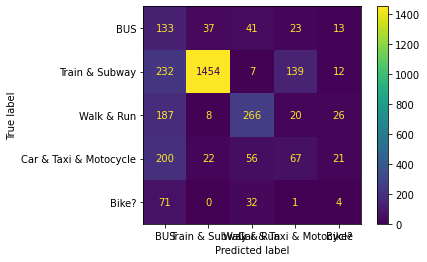

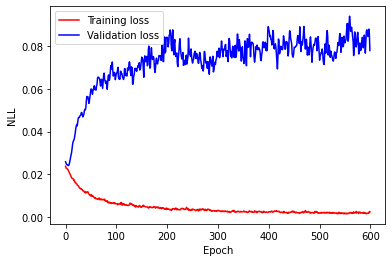

In [96]:
batch_size = 64
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        # print(f"slc: {slc}")
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(f'output.shape: {output.shape}, y_batch.shape: {y_batch.shape}')
        # print(output)
        # print(y_batch)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.08515625, 0.08515625, 0.08515625, 0.337109375, 0.403125, 0.39453125, 0.393359375, 0.389453125, 0.34921875, 0.28984375, 0.27109375, 0.280078125, 0.29296875, 0.31484375, 0.35, 0.38125, 0.401171875, 0.421875, 0.408203125, 0.395703125, 0.40078125, 0.4, 0.4078125, 0.441015625, 0.452734375, 0.4421875, 0.457421875, 0.478515625, 0.49765625, 0.538671875, 0.501953125, 0.471875, 0.519921875, 0.530078125, 0.546875, 0.565625, 0.555859375, 0.562109375, 0.567578125, 0.55546875, 0.5890625, 0.586328125, 0.587890625, 0.5875, 0.577734375, 0.583203125, 0.58515625, 0.6015625, 0.594921875, 0.59921875, 0.602734375, 0.62421875, 0.609765625, 0.60859375, 0.619921875, 0.61875, 0.65, 0.642578125, 0.640625, 0.62421875, 0.644921875, 0.6640625, 0.65546875, 0.669140625, 0.66953125, 0.6734375, 0.640234375, 0.660546875, 0.6734375, 0.675390625, 0.687890625, 0.683203125, 0.694140625, 0.688671875, 0.696875, 0.689453125, 0.706640625, 0.70546875, 0.72109375, 0.7265625, 0.734765625, 0.72734375, 0.7234375, 0.74765625, 0.75

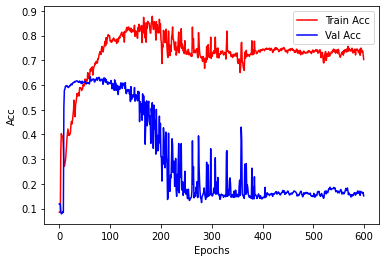


Test set Acc:  0.257212


In [86]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))